# Functions designed to upsize images

We assume that we don't downsize in one dimension and upsize in another dimension. Two main functions are defined. An up-sizing function with billinear and cubic interpolation along with both guassian and average convolutions for down-sizing.

In [1]:
# export
import numpy as np
import cv2

In [2]:
import pdb

In [3]:
# export
from Export.nb_PixelManipulation import *
from Export.nb_HistogramEqualisation import *

## Coordinate Transformation

In [4]:
#export
def calcualteSizeTransParams(old_dim, target_dim):
    a = (old_dim - 2)/target_dim
    b = 0.5
    return lambda x : a * x + b

def createPixelTransform(old_size, target_size):
    y_resize = calcualteSizeTransParams(old_size[1], target_size[1])
    x_resize = calcualteSizeTransParams(old_size[0], target_size[0])
    return lambda x, y : (x_resize(x), y_resize(y))

In [5]:
test_func = calcualteSizeTransParams(4, 7)

In [6]:
test_func(0)

0.5

In [7]:
assert(test_func(0) == .5)

In [8]:
px_trans = createPixelTransform((4,4), (7,7))

In [9]:
px_trans(7,7)

(2.5, 2.5)

In [10]:
assert(np.all(np.ceil(px_trans(7,7)) == (4-1,4-1)))

In [11]:
px_trans = createPixelTransform((3,5), (7,9))

In [12]:
px_trans(7,9)

(1.5, 3.5)

In [13]:
assert(np.all(np.ceil(px_trans(7,9)) == (3-1,5-1)))

## Loading in an example image

In [14]:
frog_img = cv2.imread('Images/dat_boi.jpg')

In [15]:
frog_small = cv2.resize(frog_img, dsize = (320, 320), interpolation = cv2.INTER_AREA)

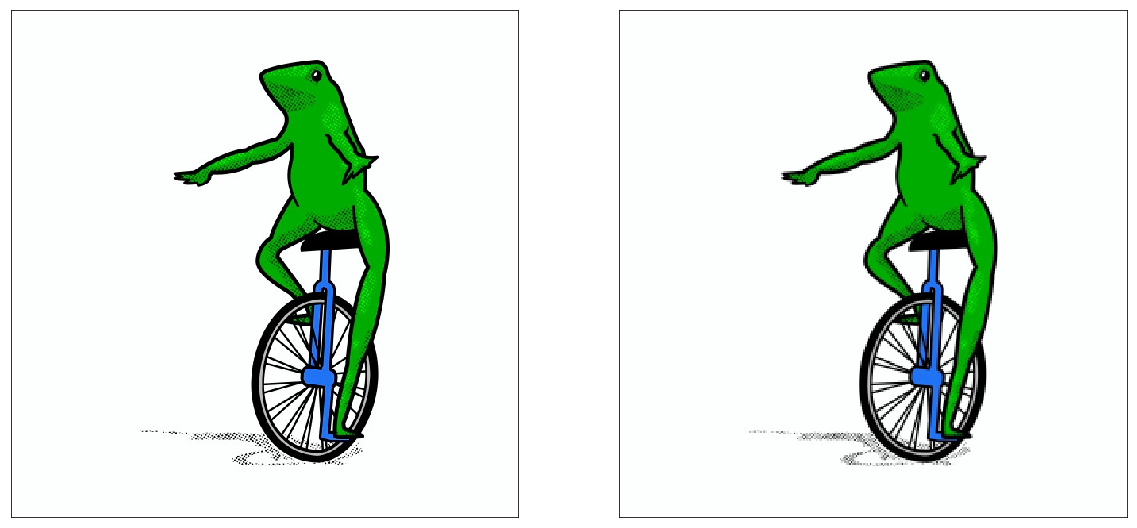

In [16]:
compareTwoImages(frog_img, frog_small)

## Functions for upsizing the image

In [17]:
#export

def extractPxWindow(coord : np.array, img : np.array, pixel_window : np.array):
    i, j = coord
    pixel_window[:] = [img[i, j, :], 
        img[i, j + 1, :], 
        img[i + 1, j, :], 
        img[i + 1, j + 1, :]]

def getTargetIndices(float_coord : np.array, ind_arr : np.array):
    i, j = np.int32(np.floor(float_coord))
    ind_arr[:] = [[i, j], [i, j + 1], [i + 1, j], [i + 1, j + 1]]

def areaMultiply(px : np.array):
    return np.abs(px[0] * px[1])

def getAreaArray(float_coord : np.array, target_indices : np.array, area_weights : np.array):
    area_weights[:] =(
        areaMultiply(float_coord - target_indices[3]),
        areaMultiply(float_coord - target_indices[2]),
        areaMultiply(float_coord - target_indices[1]),
        areaMultiply(float_coord - target_indices[0]))

def getValueArray(pixel_window : np.array, k : int, value_weights : np.array):
    value_weights[:] = (
        pixel_window[0, k], pixel_window[1, k],
        pixel_window[2, k], pixel_window[3, k])

def areaInterpolation(pixel_window : np.array, float_px : np.array, target_indices : np.array,
        k : int, area_weights : np.array, value_weights : np.array):
    getAreaArray(float_px, target_indices, area_weights)
    getValueArray(pixel_window, k, value_weights)
    return np.uint8(np.rint(np.dot(area_weights, value_weights)))

def prepareInterpolationBookKeepingVars(img : np.array):
    i, j, k = 0, 0, 0
    float_coord = np.ndarray(2, dtype = np.float64)
    float_coord.fill(0.5)
    current_inds  = np.ndarray((4,2), dtype = np.int32, buffer = np.array([0,0,0,1,1,0,1,1]))
    latest_inds = current_inds[0]
    pixel_window = np.ndarray((4,3), dtype = np.uint8)
    extractPxWindow(latest_inds, img, pixel_window)
    area_weights = np.ndarray(4, np.float64)
    value_weights = np.ndarray(4, np.float64)
    return i, j, k, float_coord, current_inds, latest_inds, pixel_window, area_weights, value_weights


In [18]:
# export

# Different interpolation methods not implemented
def upsizeImage(img : np.array, target_size : tuple, interpolation_method = None):
        
    img, height, width, channels, im_size = getChannels(img)
    target_hei, target_wid, target_chn = target_size
    if target_chn != channels : print('Target channels not equal to input.'); return
    px_transform = createPixelTransform((height, width), target_size)
    output_img = np.zeros(target_size, dtype = np.uint8)
    
    i, j, k, float_input_coord, current_target_inds, latest_target_inds, pixel_window, area_weights, value_weights = (
        prepareInterpolationBookKeepingVars(img))
    
    for px in np.nditer(output_img, op_flags = ['writeonly']):
        if np.any(np.int32(np.floor(float_input_coord)) != latest_target_inds):
            getTargetIndices(float_input_coord, current_target_inds)
            extractPxWindow(current_target_inds[0], img, pixel_window)
            latest_target_inds = current_target_inds[0]
        px[...] = areaInterpolation(pixel_window, float_input_coord, current_target_inds, k, area_weights, value_weights)
        i, j, k = iterateImage(i, j, k, channels, target_wid)
        if k % channels == 0:
            float_input_coord = px_transform(i, j)
        
    return output_img

## Viewing the results

In [19]:
frog_resize = upsizeImage(frog_small, (640, 640, 3), None)

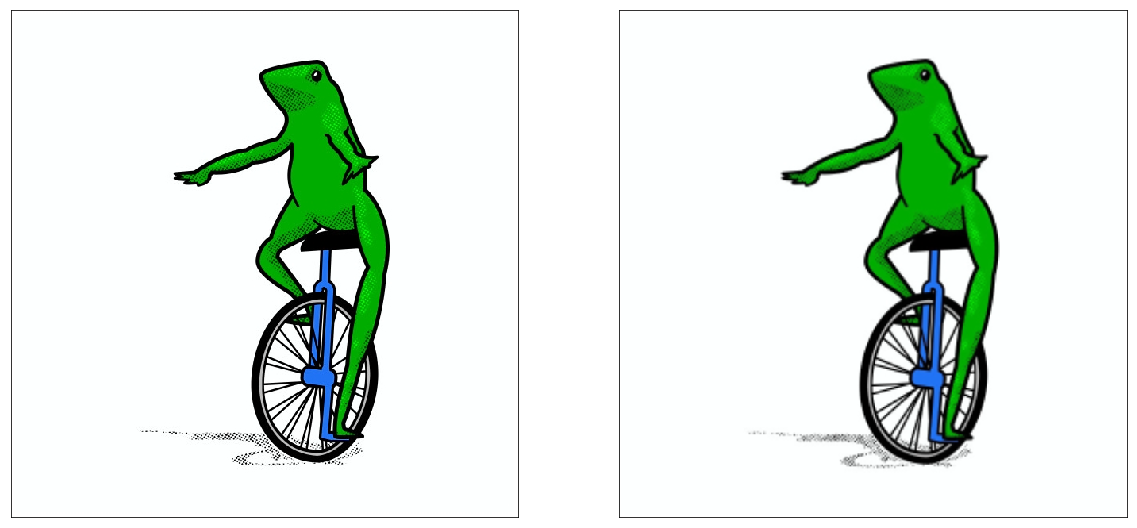

In [20]:
compareTwoImages(frog_img, frog_resize)

Now we want to resize in two different dimensions, we get a short fat frog. Since we upsized an image to something smaller then the original in the x-dimenion, we can introduce artifacts around the edges of the frog.

In [21]:
frog_resize = upsizeImage(frog_small, (317, 379, 3), None)

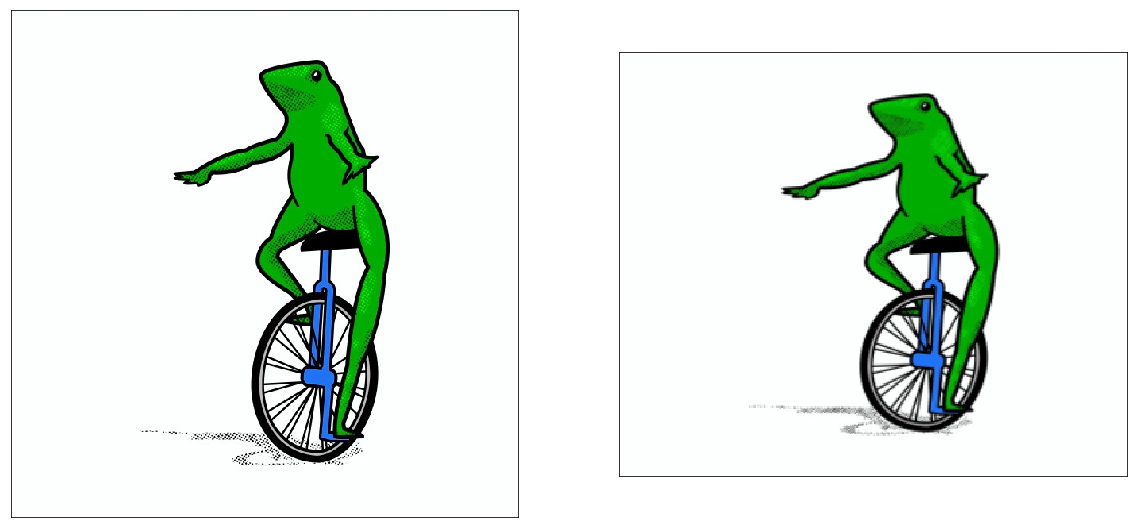

In [22]:
compareTwoImages(frog_img, frog_resize)

## Export

In [23]:
!python notebook2script.py UpScalingImages.ipynb

Converted UpScalingImages.ipynb to Export\nb_UpScalingImages.py
